In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [3]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [4]:
# MNIST IMAGE --> Tensors
transforms = transforms.ToTensor()

In [5]:
train_data = datasets.MNIST(root='../Data/', train=True, download=True, transform=transforms)

In [6]:
test_data = datasets.MNIST(root='../Data/', train=False, download=True, transform=transforms)

In [7]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../Data/
    Split: Train
    StandardTransform
Transform: ToTensor()

In [8]:
type(train_data)

torchvision.datasets.mnist.MNIST

In [9]:
train_data[0]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [10]:
image,label = train_data[0]

In [11]:
image.shape

torch.Size([1, 28, 28])

In [12]:
label

5

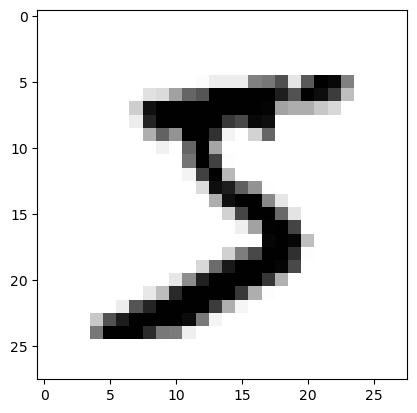

In [13]:
plt.imshow(image.reshape((28,28)), cmap='gist_yarg')

In [14]:
torch.manual_seed(101)

train_loader = DataLoader(train_data, batch_size=100, shuffle=True)

test_loader = DataLoader(test_data, batch_size=500, shuffle=False)

In [15]:
from torchvision.utils import make_grid
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}')) # formatting

In [16]:
# just first batch
for images, labels in train_loader:
    break

In [17]:
images.shape

torch.Size([100, 1, 28, 28])

In [18]:
labels.shape

torch.Size([100])

Labels:  [   7    2    3    5    8    5    3    6    9    9    1    3]


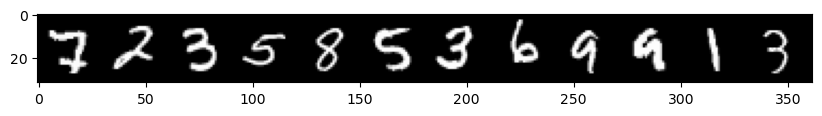

In [19]:
# print the first 12 labels
print('Labels: ', labels[:12].numpy())

# print first 12 images
im = make_grid(images[:12], nrow=12) # the default nrow is 8
plt.figure(figsize=(10,4))
# we need to transpose the images from CWH to WHC (W = width, H = height, C = color channel)
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

In [20]:
class MultilayerPerceptron(nn.Module):
    # in_sz = 28*28 px, out_sz = 10 numbers
    def __init__(self, in_sz=784, out_sz=10, layers=[120,84]):
        super().__init__()
        self.fc1 = nn.Linear(in_sz, layers[0]) # fully connected layer 1
        self.fc2 = nn.Linear(layers[0], layers[1])
        self.fc3 = nn.Linear(layers[1], out_sz)

    def forward(self, X):
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)

        return F.log_softmax(X, dim=1) # multi class classification

In [21]:
torch.manual_seed(101)
model = MultilayerPerceptron()
model

MultilayerPerceptron(
  (fc1): Linear(in_features=784, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [22]:
# ANN ---> CNN use lot less parameters than ANN
for param in model.parameters():
    print(param.numel())

94080
120
10080
84
840
10


In [23]:
# 105214 total parameters

In [24]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [25]:
images.shape # convert to ----> [100,784]

torch.Size([100, 1, 28, 28])

In [26]:
images.view(100,-1).shape

torch.Size([100, 784])

In [27]:
import time
start_time = time.time()

# training
epochs = 10

# trackers (just for printing statistics)
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0

    # run training batches
    for b, (X_train, y_train) in enumerate(train_loader): # batch no., (image, label)
        b = b+1

        y_pred = model(X_train.view(100,-1)) # flatten out the data and feed to model
        loss = criterion(y_pred, y_train)

        # next line will do:
        # at the end, there will be 10 neurons (10 numbers)
        # y_pred be like [0,1, 0.0, 0,2, ..., 0.8] for numbers
        # grab the max value from thte y_pred columns and get its index
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum() # how many are correct
        trn_corr = trn_corr + batch_corr

        # update parameters (back propagation)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if b%200 == 0:
            acc = trn_corr.item()*100/(100*b)
            print(f'epoch {i} batch {b} loss: {loss.item()} accuracy:{acc}')

    train_losses.append(loss.item())
    train_correct.append(trn_corr)

    # run test batches
    with torch.no_grad(): # not updating biases
        for b, (X_test, y_test) in enumerate(test_loader):
            y_val = model(X_test.view(500, -1))
            predicted = torch.max(y_val.data, 1)[1]
            tst_corr += (predicted == y_test).sum()

    loss = criterion(y_val, y_test)
    test_losses.append(loss.item())
    test_correct.append(tst_corr)


total_time = time.time() - start_time
print(f'Duration: {total_time/60} mins')

epoch 0 batch 200 loss: 0.23541301488876343 accuracy:83.25
epoch 0 batch 400 loss: 0.35372811555862427 accuracy:87.5275
epoch 0 batch 600 loss: 0.13651520013809204 accuracy:89.57333333333334
epoch 1 batch 200 loss: 0.24385471642017365 accuracy:94.825
epoch 1 batch 400 loss: 0.14487527310848236 accuracy:95.06
epoch 1 batch 600 loss: 0.07246958464384079 accuracy:95.36
epoch 2 batch 200 loss: 0.08372026681900024 accuracy:96.52
epoch 2 batch 400 loss: 0.06578098982572556 accuracy:96.625
epoch 2 batch 600 loss: 0.06683743745088577 accuracy:96.72
epoch 3 batch 200 loss: 0.1206488311290741 accuracy:97.63
epoch 3 batch 400 loss: 0.06358520686626434 accuracy:97.4925
epoch 3 batch 600 loss: 0.032477881759405136 accuracy:97.51333333333334
epoch 4 batch 200 loss: 0.10566626489162445 accuracy:98.18
epoch 4 batch 400 loss: 0.04522024095058441 accuracy:98.0325
epoch 4 batch 600 loss: 0.049620434641838074 accuracy:98.02166666666666
epoch 5 batch 200 loss: 0.010442550294101238 accuracy:98.385
epoch 5 b

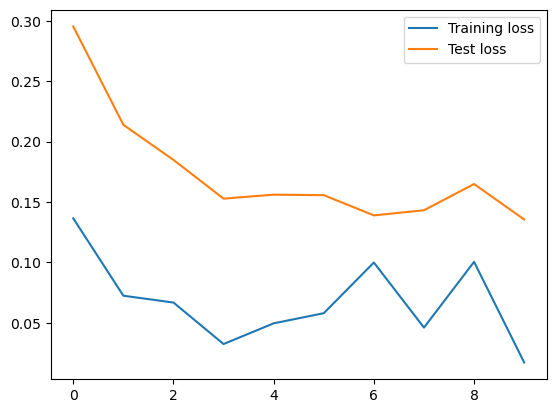

In [28]:
plt.plot(train_losses, label="Training loss")
plt.plot(test_losses, label="Test loss")
plt.legend()

In [29]:
train_acc = [t/600 for t in train_correct]

In [31]:
test_acc = [t/100 for t in test_correct]

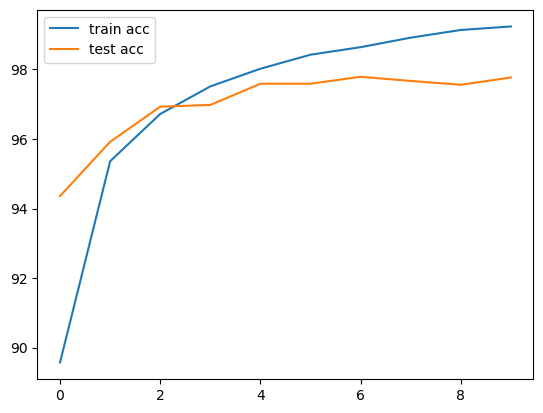

In [32]:
plt.plot(train_acc, label='train acc')
plt.plot(test_acc, label='test acc')
plt.legend()

In [33]:
# new unseen data
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

In [35]:
with torch.no_grad():
    correct = 0

    for X_test, y_test in test_load_all:
        y_val = model(X_test.view(len(X_test),-1))
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()

In [37]:
correct.item()/len(test_data)*100

97.77

In [38]:
confusion_matrix(predicted.view(-1),y_test.view(-1))

array([[ 969,    0,    3,    0,    1,    2,    5,    2,    5,    1],
       [   0, 1125,    3,    0,    0,    0,    3,    8,    0,    2],
       [   1,    3, 1004,    2,    2,    0,    1,   10,    4,    0],
       [   2,    2,    6,  991,    0,   11,    1,    2,    2,    4],
       [   2,    0,    3,    0,  964,    3,    3,    2,    2,   12],
       [   0,    0,    0,    6,    0,  865,    4,    1,    2,    4],
       [   1,    1,    1,    0,    5,    3,  940,    1,    1,    0],
       [   0,    0,    3,    3,    1,    1,    0,  986,    3,    0],
       [   4,    4,    9,    2,    1,    6,    1,    2,  951,    4],
       [   1,    0,    0,    6,    8,    1,    0,   14,    4,  982]])